This will plot and compare the resulting data. To run this, make sure that you have already generated all data you want to be compared. For instructions on how to run the generation, see README-new.md

In [102]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import numpy as np
from pylatex import Document, Package, Section, NoEscape

from cloudmesh.common.Shell import Shell
from cloudmesh.common.parameter import Parameter
from cloudmesh.common.dotdict import dotdict
from cloudmesh.common.util import writefile

from cloudmesh.common.util import banner
from analysis import get_data, read_log, generate_df
pd.options.mode.chained_assignment = None 


In [2]:
sizes = [100,1000,5000,10000,50000,100000,500000,1000000,2000000,4000000,5000000,6000000,8000000,10000000]

In [3]:
def average_df(df):
    _df = df.groupby(['p','size','repeat','sort','user','node','t','c'], sort=True, as_index=False).agg({'time':'mean'})
    _df.reset_index()
    return _df

In [4]:
df = generate_df()
index_max_size = df[(df['size'] == 50000000) | (df['size'] == 500)].index
df.drop(index_max_size, inplace=True)
df = average_df(df)
print(df.to_string())

      p      size  repeat sort  user  node     t     c     time
0     1       100      10   mp  alex  v100  None  None   0.0150
1     1       100      10  seq  alex  v100  None  None   0.0006
2     1      1000      10   mp  alex  v100  None  None   0.0206
3     1      1000      10  seq  alex  v100  None  None   0.0055
4     1      5000      10   mp  alex  v100  None  None   0.0622
5     1      5000      10  seq  alex  v100  None  None   0.0269
6     1     10000      10   mp  alex  v100  None  None   0.0939
7     1     10000      10  seq  alex  v100  None  None   0.0563
8     1     50000      10   mp  alex  v100  None  None   0.3858
9     1     50000      10  seq  alex  v100  None  None   0.2859
10    1    100000      10   mp  alex  v100  None  None   0.7636
11    1    100000      10  seq  alex  v100  None  None   0.5455
12    1    500000      10   mp  alex  v100  None  None   3.4632
13    1    500000      10  seq  alex  v100  None  None   3.1286
14    1   1000000      10   mp  alex  v1

In [44]:
def average_increase(df, sort):
    _df = df[df['sort'] == sort]
    _df = _df.groupby(['size'], sort=True, as_index=False).agg({'time':'mean'})
    # print(_df)
    avg = _df[_df['size'] == 10000000].iat[0, 1] - _df[_df['size'] == 1000000].iat[0, 1]
    avg = avg / 9.0
    return avg
    

average_increase(df, "seq")

8.754044444444444

In [5]:
def get_values(df, processes, sizes, sorts, users, nodes):
    _df = df[df['p'].isin(processes) & df['size'].isin(sizes) & df['sort'].isin(sorts) & df['user'].isin(users) & df['node'].isin(nodes)]
    return _df

In [57]:
df = get_values(df, list(range(1,30)), [10000000], ["mp","mpi","seq"], ["alex"], ["v100"])

In [48]:
def calculate_speedup(df):
    frames = []
    gb = df.groupby(['size','repeat','user','node','t','c'])
    for x in gb.groups:
        _df = gb.get_group(x)
        seq_time = _df[_df['sort'] == 'seq'].iat[0, 8]
        # print(seq_time)
        scale = 1 / seq_time
        # print(scale)
        
        _df['speedup'] = _df['time'].rdiv(seq_time)
        frames.append(_df)
    ans = pd.concat(frames)
    return ans

In [5]:
def calculate_efficiency(df):
    ans = calculate_speedup(df)
    ans['efficiency'] = ans['speedup'] / ans['p']
    return ans

In [39]:
def calculate_strong_speedup(df):
    prop_mp = 0.65 # time proportion of multiprocessing merge sort that can be parallelized
    prop_mpi = 0.70 # time proportion of MPI merge sort that can be parallelized
    conditions = [
        (df['sort'] == 'seq'),
        (df['sort'] == 'mp'),
        (df['sort'] == 'mpi')
    ]

    values = [1, prop_mp, prop_mpi]

    df['prop'] = np.select(conditions, values)
    df['strong_speedup'] = 1 / ((1 - df['prop']) + (df['prop'] / df['p']))
    df = df.drop(columns=['prop'])
    return df


In [115]:
def plot_benchmark(df, x_axis, y_axis, hue, bound=None, tag=None):
    hues = df[hue].unique()
    hues = [str(hue) for hue in hues]
    # name the image
    hues_name = "-".join(hues)
    name = f"{y_axis}-by-{x_axis}-{hue}-{tag}"
    sns.lineplot(data=df, x=x_axis, y=y_axis, hue=hue, errorbar=None)
    if bound != None:
        sns.lineplot(data=df, x=x_axis, y=bound, hue=hue, linestyle="dashed", errorbar=None)
    plt.title(name)
    plt.savefig(f"images/{name}.png")
    plt.savefig(f"images/{name}.pdf")

In [47]:
ans = df
ans = get_values(ans, list(range(1,30)), [1000,10000,100000,1000000,10000000], ["mp","mpi","seq"], ["alex"], ["v100"])
ans = ans.groupby(['size','sort'], sort=True, as_index=False).agg({'time':'mean'})
ans = ans.pivot(index='size',columns='sort')

ans

time                    
sort             mp        mpi      seq
size                                   
1000       0.057400   3.034900   0.0055
10000      0.088983   3.039633   0.0563
100000     0.380683   3.113067   0.5455
1000000    2.871408   4.491867   6.8242
10000000  27.223592  19.861967  85.6106

In [103]:
a = df.to_latex()
writefile("a.tex", a)

/var/folders/9z/_9vl5v9s7mgc48qt12wb56d40000gr/T/ipykernel_21129/2101812095.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  a = df.to_latex()


In [124]:
a = df.copy()
# a = get_values(a, [], sizes, ['mp', 'mpi', 'seq'], ['alex'], ['v100'])
a = a[['size', 'time', 'sort', 'p']]
a

,size,time,sort,p
0,100,0.0150,mp,1
1,100,0.0006,seq,1
2,1000,0.0206,mp,1
3,1000,0.0055,seq,1
4,5000,0.0622,mp,1
...,...,...,...,...
325,100000,0.3543,mp,24
326,500000,1.2649,mp,24
327,1000000,2.3434,mp,24
328,5000000,10.1919,mp,24


In [125]:
mpi = a.copy()
mp = a.copy()
seq = a.copy()
mpi = mpi[mpi['sort'] == 'mpi']
mp = mp[mp['sort'] == 'mp']
seq = seq[seq['sort'] == 'seq']

In [126]:
mpi

,size,time,sort,p
29,100,2.8829,mpi,2
31,1000,2.9598,mpi,2
33,5000,2.8688,mpi,2
35,10000,2.9348,mpi,2
37,50000,2.8999,mpi,2
39,100000,2.9250,mpi,2
41,500000,3.6026,mpi,2
43,1000000,4.4102,mpi,2
45,2000000,5.6835,mpi,2
47,4000000,8.1028,mpi,2


In [145]:
mpi_p = {}
mp_p = {}
seq_p = {}
for p in [2, 4, 8]:
    mpi_p[p] = mpi[mpi['p'] == p]
    mpi_p[p]['label'] = f'mpi {p} processors 1 core'

for p in range(1, 25):
    mp_p[p] = mp[mp['p'] == p]
    mp_p[p]['label'] = f'mp 1 processor {p} cores'

for p in range(1, 25):
    seq_p[p] = seq[seq['p'] == p]
    seq_p[p]['label'] = f'seq {p} processor 1 core'

<AxesSubplot: xlabel='size', ylabel='time'>

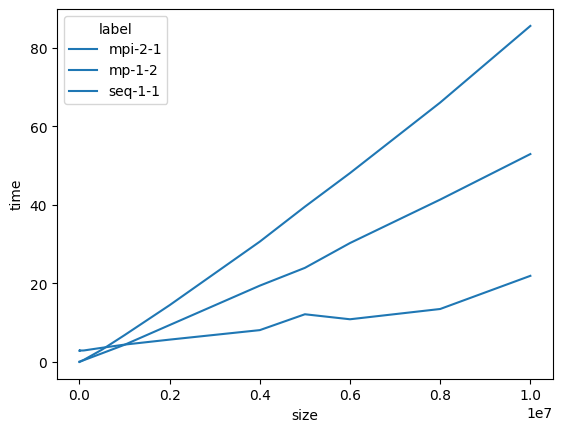

In [143]:
sns.lineplot(data=mpi_p[2], x='size', y='time', hue='label', errorbar=None)
sns.lineplot(data=mp_p[2], x='size', y='time', hue='label', errorbar=None)
sns.lineplot(data=seq_p[1], x='size', y='time', hue='label', errorbar=None)

<AxesSubplot: xlabel='size', ylabel='time'>

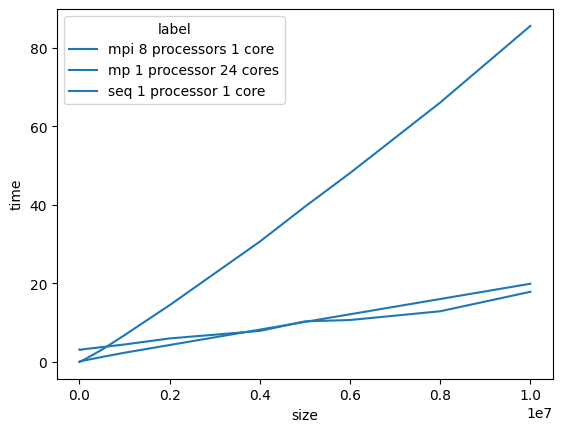

In [146]:
sns.lineplot(data=mpi_p[8], x='size', y='time', hue='label', errorbar=None)
sns.lineplot(data=mp_p[24], x='size', y='time', hue='label', errorbar=None)
sns.lineplot(data=seq_p[1], x='size', y='time', hue='label', errorbar=None)

In [92]:
def generate_table(df, processes, sizes, sorts, users, nodes, columns, label=None, tag=None):
    columns = [str(c) for c in columns]
    name = "-".join(columns)
    ans = get_values(df, processes, sizes, sorts, users, nodes)
    ans = ans[columns]
    if 'time' in columns:
        columns.remove('time')
    ans = ans.groupby(columns, sort=True, as_index=False).agg({'time':'mean'})
    # ans = ans.transpose()
    # ans = ans.pivot(index='size', columns='sort')
    # ans.columns = ans.columns.droplevel(0)
    if tag is not None:
        name = f"{name}-{tag}"

    geometry_options = {"tmargin": "1cm", "lmargin": "10cm"}
    doc = Document(geometry_options=geometry_options)
    doc.packages.append(Package('booktabs'))

    with doc.create(Section(f"{label}")) as target:
        target.append(NoEscape(ans.style.hide().to_latex(hrules=True)))
    
    doc.generate_pdf(f"images/{name}", clean_tex=False)
    # ans.style.to_latex(NoEscape(f'images/{name}.tex'))
    # lat_new = df.style.hide(axis="index").to_latex(hrules=True)



In [99]:
ans = generate_table(df, list(range(1,30)), [10000], ["mp"], ["alex"], ["v100"], ['p', 'time', 'sort'], label="Size=10000", tag="10000")
print(ans)

None


In [40]:
df = calculate_speedup(df)
df = calculate_strong_speedup(df)
df

,p,size,repeat,sort,user,node,t,c,time,speedup,strong_speedup
0,1,100,10,mp,alex,v100,None,None,0.0150,0.040000,1.000000
1,1,100,10,seq,alex,v100,None,None,0.0006,1.000000,1.000000
28,2,100,10,mp,alex,v100,None,None,0.0227,0.026432,1.481481
29,2,100,10,mpi,alex,v100,None,None,2.8829,0.000208,1.538462
56,3,100,10,mp,alex,v100,None,None,0.0255,0.023529,1.764706
...,...,...,...,...,...,...,...,...,...,...,...
289,20,10000000,10,mp,alex,v100,None,None,21.1380,4.050080,2.614379
299,21,10000000,10,mp,alex,v100,None,None,20.7588,4.124063,2.625000
309,22,10000000,10,mp,alex,v100,None,None,20.4045,4.195673,2.634731
319,23,10000000,10,mp,alex,v100,None,None,19.9842,4.283914,2.643678


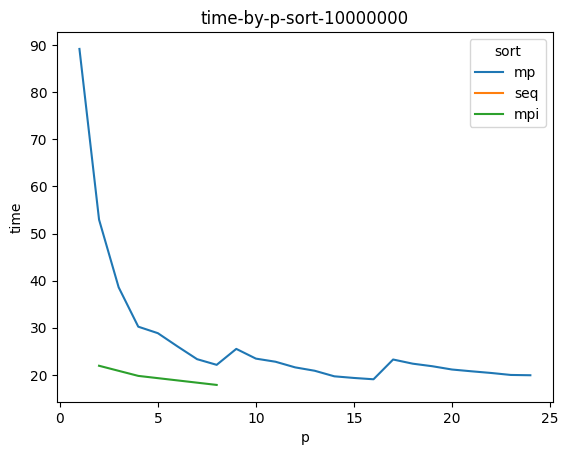

In [58]:
plot_benchmark(df, 'p', 'time', 'sort', tag='10000000')

In [ ]:
def get_values(df, processes, sizes, sorts, users, nodes):
    _df = df[df['p'].isin(processes) & df['size'].isin(sizes) & df['sort'].isin(sorts) & df['user'].isin(users) & df['node'].isin(nodes)]
    return _df

In [ ]:
df = get_values(df, list(range(1,30)), [10000000], ["mp","mpi","seq"], ["alex"], ["v100"])

In [ ]:
df

In [ ]:
plot_benchmark(df, 'p', 'time', 'sort')

In [ ]:
def calculate_weak_speedup(df):
    prop_mp = 0.30 # time proportion of multiprocessing merge sort that can be parallelized
    prop_mpi = 0.10 # time proportion of MPI merge sort that can be parallelized
    conditions = [
        (df['sort'] == 'seq'),
        (df['sort'] == 'mp'),
        (df['sort'] == 'mpi')
    ]

    values = [1, prop_mp, prop_mpi]

    df['prop'] = np.select(conditions, values)
    df['weak_speedup'] = (1 - df['prop']) + (df['prop'] * df['p'])
    df = df.drop(columns=['prop'])
    return df
